<a href="https://colab.research.google.com/github/eshaansdoshi-sketch/ML_projects/blob/main/Task1_s4ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# Step 0 — Setup & Imports (install SciPy if needed)

In [70]:
import os
from pathlib import Path
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

In [71]:
# Step 1 — Load data & basic settings

In [72]:


# Where to save figures
IMG_DIR = Path("./eda_images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

# Optional: set your known target column (e.g., "is_counterfeit"). If None, we'll try to guess.
TARGET_COL: Optional[str] = None

# Read data
df = pd.read_csv("counterfeit_products_renamed.csv")

# Basic info
print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)
print("\nMemory (MB):", round(df.memory_usage(deep=True).sum() / (1024**2), 3))

# Quick peek
display(df.head(10))

Shape: (5000, 27)

Dtypes:
item_ref              object
vendor_code           object
product_type          object
manufacturer          object
cost_usd             float64
vendor_score         float64
feedback_count         int64
image_qty              int64
desc_chars             int64
delivery_period        int64
typo_count             int64
site_age             float64
contact_valid           bool
return_clarity          bool
payment_options        int64
post_timestamp        object
vendor_nation         object
dispatch_loc          object
page_hits              int64
sales_vol              int64
saved_items            int64
trust_seals            int64
guarantee_term         int64
wholesale_avail         bool
payment_anomaly         bool
geo_inconsistency     object
fraud_indicator         bool
dtype: object

Memory (MB): 2.613


,item_ref,vendor_code,product_type,manufacturer,cost_usd,vendor_score,feedback_count,image_qty,desc_chars,delivery_period,...,dispatch_loc,page_hits,sales_vol,saved_items,trust_seals,guarantee_term,wholesale_avail,payment_anomaly,geo_inconsistency,fraud_indicator
0,dcb12716,seller_5426,Electronics,DigitalPro,218.54,4.9,5291,7,220,7,...,JP,3454,99,23,2,21,True,False,True,False
1,d1f8b777,seller_4385,Luxury Goods,TechCrop,NaN,3.2,29,2,179,41,...,CA,4127,252,88,0,9,False,False,False,True
2,9989f13a,seller_2528,Fashion,FashionForward,18.87,3.9,14,2,100,25,...,CN,3212,306,6,4,8,True,True,False,True
3,4e008120,seller_8099,Electronics,CircuitMaster,79.27,4.9,8533,4,976,10,...,CN,1488,7,46,2,13,False,False,False,False
4,933b65ba,seller_7873,Luxury Goods,PremiumCraft,225.98,3.8,7655,4,589,6,...,DE,171,9,5,3,13,False,False,False,False
5,52a410fa,seller_7863,Pharmaceuticals,BioMed Solutions,NaN,4.0,7729,9,451,9,...,NaN,347,23,12,0,14,False,False,False,False
6,59e1a27b,seller_6618,Pharmaceuticals,BeautyLu×,NaN,1.0,8,2,178,25,...,GB,401,34,2,0,4,False,False,False,True
7,b8fa970d,seller_3454,Electronics,NaturalGl0w,186.00,3.0,27,1,121,25,...,FR,3655,215,36,2,11,False,False,False,True
8,3c4f5456,seller_1502,Fashion,TrendSetter,336.90,4.8,5156,5,812,3,...,DE,4503,358,26,0,14,False,False,False,False
9,f4068089,seller_7019,Fashion,ClassicWear,242.39,3.5,1584,5,774,7,...,IN,1767,150,14,2,3,False,False,NaN,False


In [73]:
# Step 2 — Data overview: cardinality & summaries

In [74]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = [c for c in df.columns if c not in num_cols_all]

# Cardinality
cardinality = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "n_unique_non_null": df.nunique(dropna=True).values
}).sort_values("n_unique_non_null", ascending=False).reset_index(drop=True)

display(cardinality.head(30))

# Summary stats
if num_cols_all:
    print("\nNumeric summary:")
    display(df[num_cols_all].describe().T)
else:
    print("\nNo numeric columns found.")

if cat_cols_all:
    print("\nCategorical summary:")
    display(df[cat_cols_all].describe().T)
else:
    print("\nNo categorical columns found.")

,column,dtype,n_unique_non_null
0,item_ref,object,5000
1,vendor_code,object,3828
2,cost_usd,float64,3509
3,page_hits,int64,3135
4,feedback_count,int64,3059
5,site_age,float64,2551
6,post_timestamp,object,2227
7,desc_chars,int64,945
8,sales_vol,int64,451
9,saved_items,int64,100



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
cost_usd,3652.0,224.710643,136.900310,10.12,109.825,191.815,336.615,499.84000
vendor_score,5000.0,3.732980,0.995313,1.00,3.500,4.000,4.500,5.00000
feedback_count,5000.0,3529.809200,3281.418979,0.00,85.000,2922.500,6401.500,9996.00000
image_qty,5000.0,4.686200,2.651629,1.00,2.000,5.000,7.000,9.00000
desc_chars,5000.0,463.564000,294.294690,50.00,179.000,433.500,725.250,999.00000
delivery_period,5000.0,13.462200,11.549600,1.00,5.000,10.000,18.000,44.00000
typo_count,5000.0,1.093400,1.160752,0.00,0.000,1.000,1.000,4.00000
site_age,5000.0,1467.886499,1174.386070,1.00,308.000,1320.500,2471.000,9995.29178
payment_options,5000.0,3.254000,1.357296,1.00,2.000,3.000,4.000,5.00000
page_hits,5000.0,2469.286600,1424.525316,10.00,1245.750,2433.000,3701.500,4996.00000



Categorical summary:


,count,unique,top,freq
item_ref,5000,5000,f7efbc83,1
vendor_code,5000,3828,seller_5587,5
product_type,5000,6,Luxury Goods,870
manufacturer,5000,36,LuxuryBrand,200
contact_valid,5000,2,True,3618
return_clarity,5000,2,True,3465
post_timestamp,5000,2227,2023-07-07,13
vendor_nation,5000,10,FR,524
dispatch_loc,4253,10,KR,449
wholesale_avail,5000,2,False,3998


In [75]:
# Step 3 — Missing value analysis

In [76]:
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_summary = pd.DataFrame({
    "column": df.columns,
    "missing_count": missing.values,
    "missing_pct": missing_pct.values
}).sort_values("missing_pct", ascending=False).reset_index(drop=True)

print("Missing value summary:")
display(missing_summary)

# Optional: missingness patterns (only if not too wide)
if df.shape[1] <= 25:
    pattern_series = df.isna().astype(int).astype(str).agg(''.join, axis=1)
    top_patterns = pattern_series.value_counts().head(10).rename_axis("pattern_binary").reset_index(name="rows")
    print("\nTop missingness patterns:")
    display(top_patterns)
else:
    print("\nSkipped missingness patterns (too many columns).")

Missing value summary:


,column,missing_count,missing_pct
0,cost_usd,1348,26.96
1,geo_inconsistency,1249,24.98
2,dispatch_loc,747,14.94
3,product_type,0,0.00
4,manufacturer,0,0.00
5,vendor_score,0,0.00
6,feedback_count,0,0.00
7,image_qty,0,0.00
8,desc_chars,0,0.00
9,vendor_code,0,0.00



Skipped missingness patterns (too many columns).


In [77]:
# Step 4 — Data quality checks (duplicates, constant columns, negatives, empty strings)

In [78]:
n_dup = int(df.duplicated().sum())
print("Duplicate rows:", n_dup)

# Constant columns
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
print("Constant columns:", constant_cols if constant_cols else "None")

# Negative values (for numeric columns)
if num_cols_all:
    neg_vals = pd.DataFrame({
        "column": num_cols_all,
        "negative_value_count": [int((df[c] < 0).sum()) for c in num_cols_all]
    }).sort_values("negative_value_count", ascending=False)
    print("\nNegative values in numeric columns (may be invalid for fields like price/qty):")
    display(neg_vals)
else:
    print("\nNo numeric columns to check for negatives.")

# Empty/whitespace in string-like columns
def count_empty_like(s: pd.Series) -> int:
    if not pd.api.types.is_string_dtype(s):
        return 0
    return int(s.fillna("").str.strip().eq("").sum())

empty_like = [{"column": c, "empty_or_whitespace_count": count_empty_like(df[c])} for c in cat_cols_all]
empty_like_summary = pd.DataFrame(empty_like).sort_values("empty_or_whitespace_count", ascending=False) if empty_like else pd.DataFrame()
print("\nEmpty/whitespace-like categorical entries:")
display(empty_like_summary if not empty_like_summary.empty else pd.DataFrame({"note": ["No categorical columns"]}))

Duplicate rows: 0
Constant columns: None

Negative values in numeric columns (may be invalid for fields like price/qty):


,column,negative_value_count
0,cost_usd,0
1,vendor_score,0
2,feedback_count,0
3,image_qty,0
4,desc_chars,0
5,delivery_period,0
6,typo_count,0
7,site_age,0
8,payment_options,0
9,page_hits,0



Empty/whitespace-like categorical entries:


,column,empty_or_whitespace_count
0,item_ref,0
1,vendor_code,0
2,product_type,0
3,manufacturer,0
4,contact_valid,0
5,return_clarity,0
6,post_timestamp,0
7,vendor_nation,0
8,dispatch_loc,0
9,wholesale_avail,0


In [79]:
# Step 5 — Outlier detection (IQR method)

In [80]:
def iqr_outlier_counts(series: pd.Series) -> Tuple[int, float, float]:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or pd.isna(iqr):
        return 0, q1, q3
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    count = int(((series < lower) | (series > upper)).sum())
    return count, lower, upper

outlier_records = []
for c in num_cols_all:
    s = df[c].dropna()
    cnt, lo, hi = iqr_outlier_counts(s)
    outlier_records.append({"column": c, "outlier_count": cnt, "lower_fence": lo, "upper_fence": hi})

outlier_summary = pd.DataFrame(outlier_records).sort_values("outlier_count", ascending=False)
print("IQR outlier summary (numeric):")
display(outlier_summary.head(20))

IQR outlier summary (numeric):


,column,outlier_count,lower_fence,upper_fence
6,typo_count,726,-1.500,2.500
1,vendor_score,470,2.000,6.000
5,delivery_period,322,-14.500,37.500
10,sales_vol,85,-192.500,411.500
7,site_age,10,-2936.500,5715.500
0,cost_usd,0,-230.360,676.800
4,desc_chars,0,-640.375,1544.625
3,image_qty,0,-5.500,14.500
2,feedback_count,0,-9389.750,15876.250
8,payment_options,0,-1.000,7.000


In [81]:
print(df['fraud_indicator'])

0       False
1        True
2        True
3       False
4       False
        ...  
4995    False
4996     True
4997    False
4998     True
4999    False
Name: fraud_indicator, Length: 5000, dtype: bool


In [82]:
# Filling in missing values

In [83]:
'''for col in num_cols_all:
    df[col] = df[col].fillna(df[col].median())

# Categorical features → fill with mode
for col in cat_cols_all:
    df[col] = df[col].fillna(df[col].mode()[0])

# Target variable → drop rows if missing
#df = df.dropna(subset=['fraud_indicator'])'''


"for col in num_cols_all:\n    df[col] = df[col].fillna(df[col].median())\n\n# Categorical features → fill with mode\nfor col in cat_cols_all:\n    df[col] = df[col].fillna(df[col].mode()[0])\n\n# Target variable → drop rows if missing\n#df = df.dropna(subset=['fraud_indicator'])"

In [84]:
# Step 6 — Distributions (histograms & bar charts)

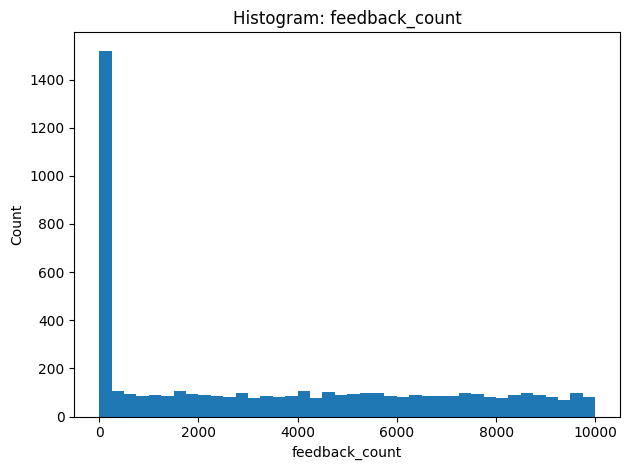

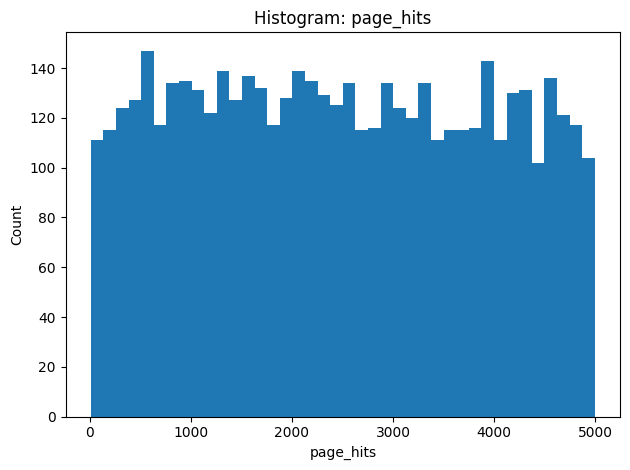

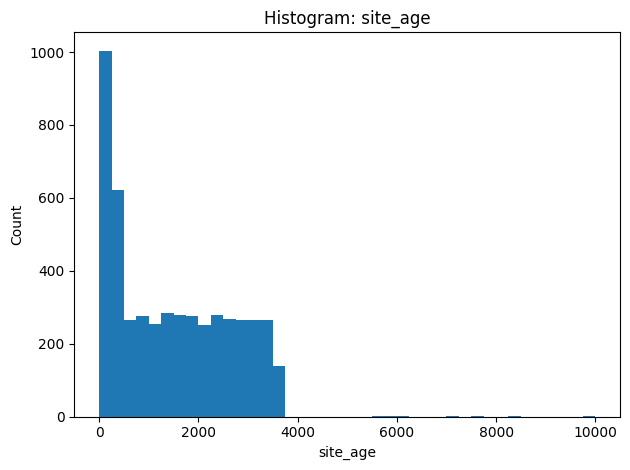

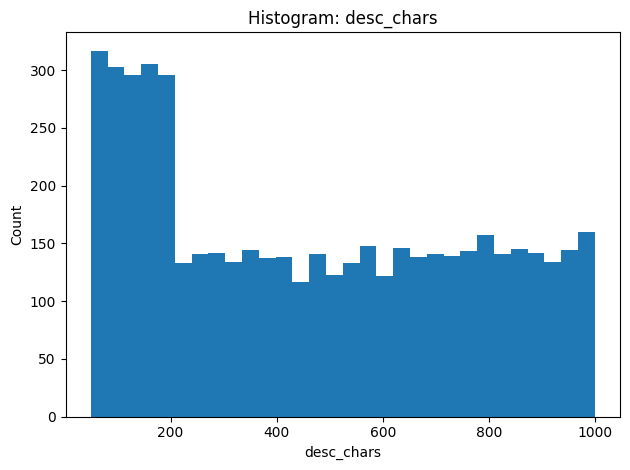

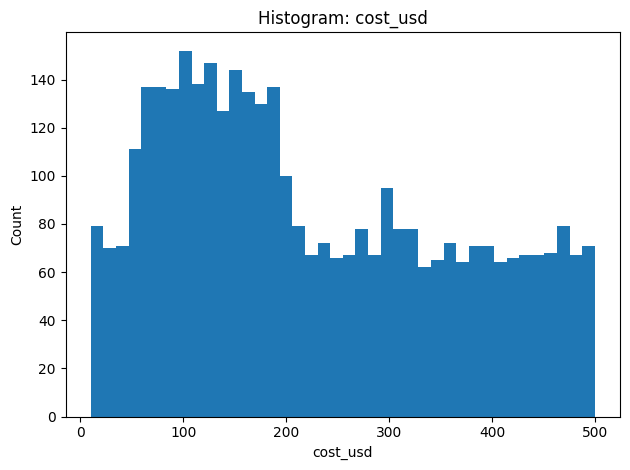

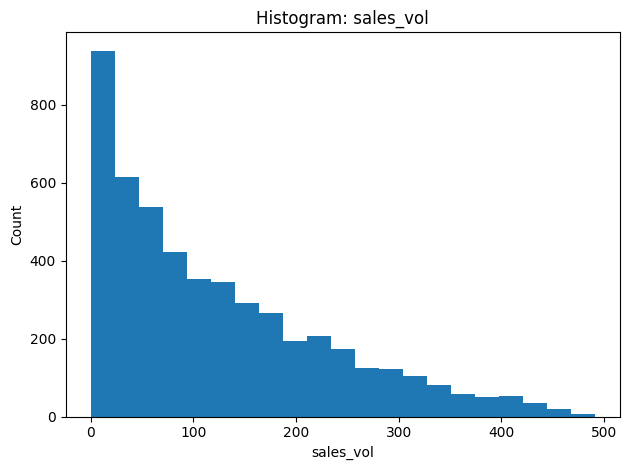

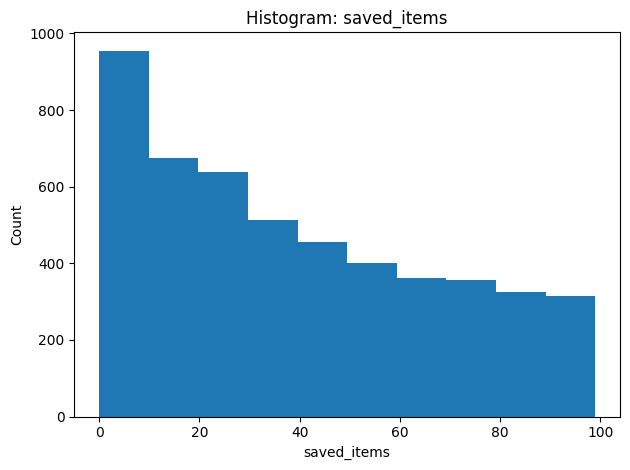

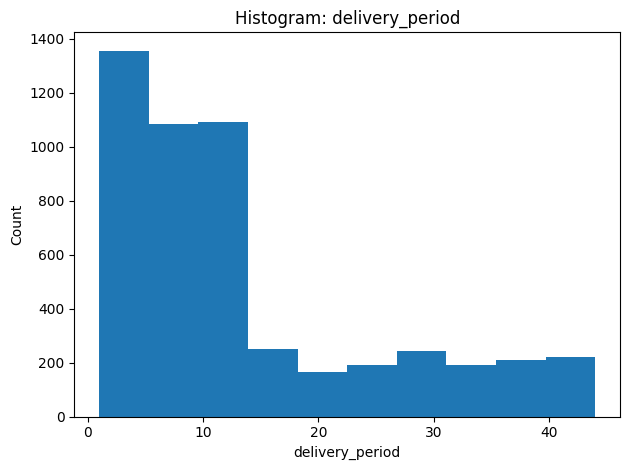

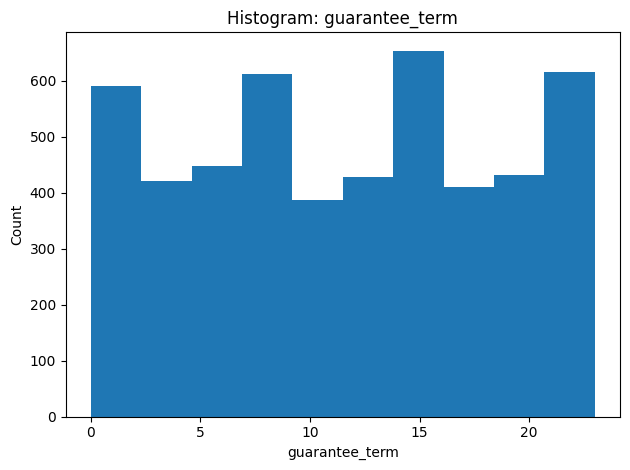

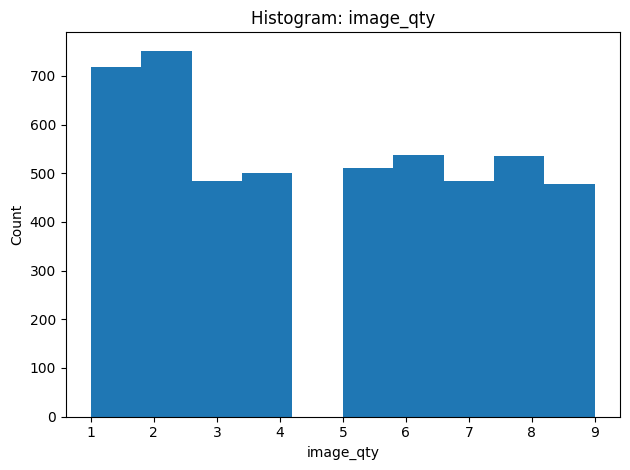

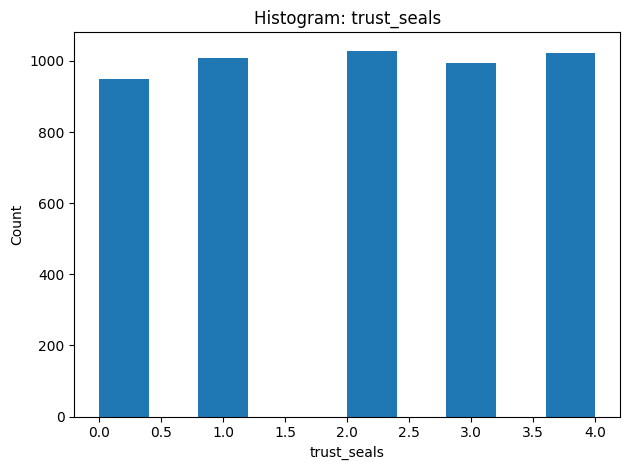

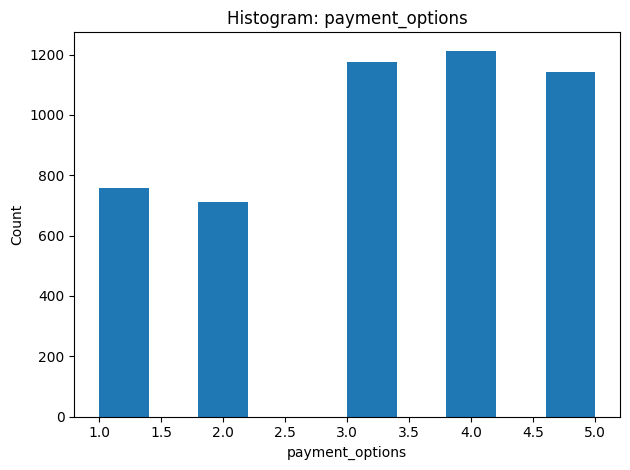

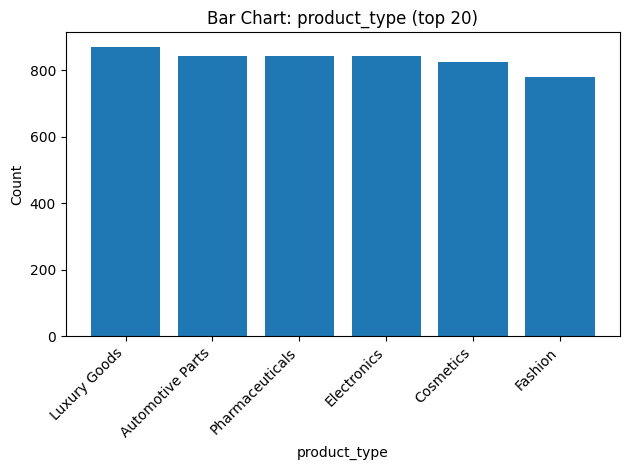

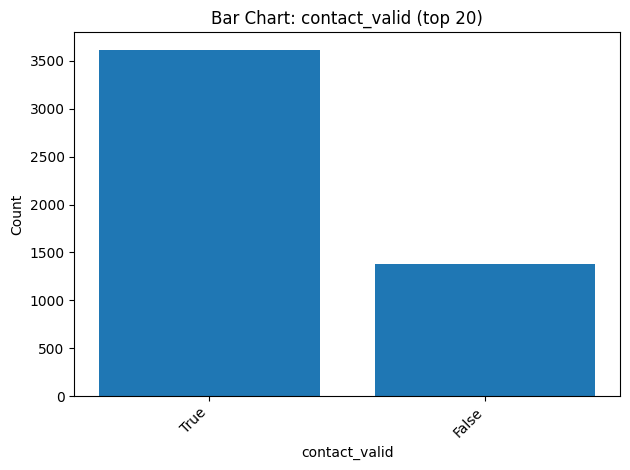

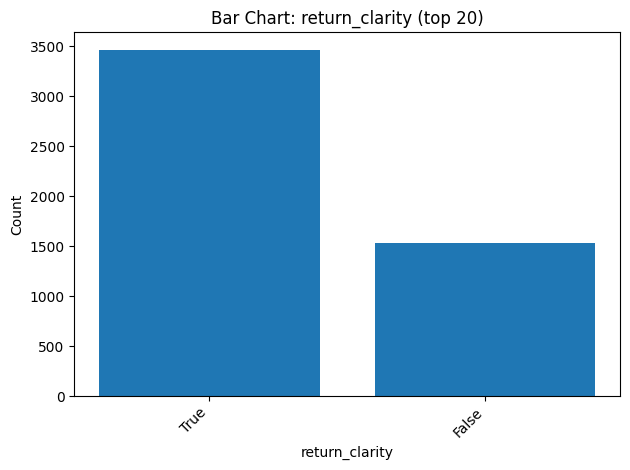

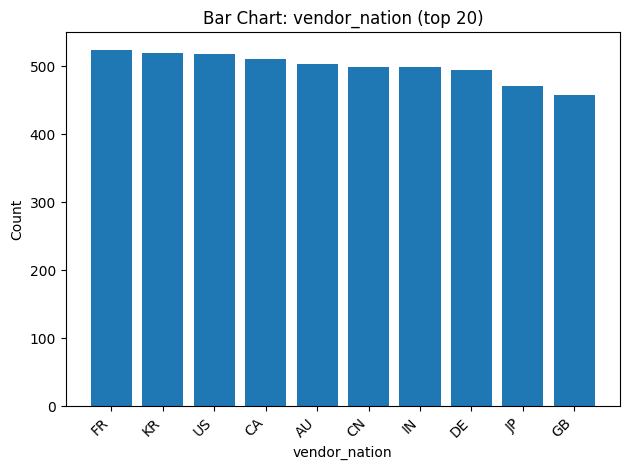

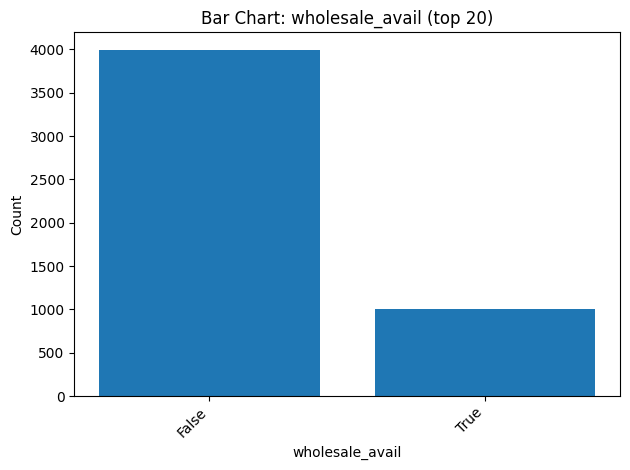

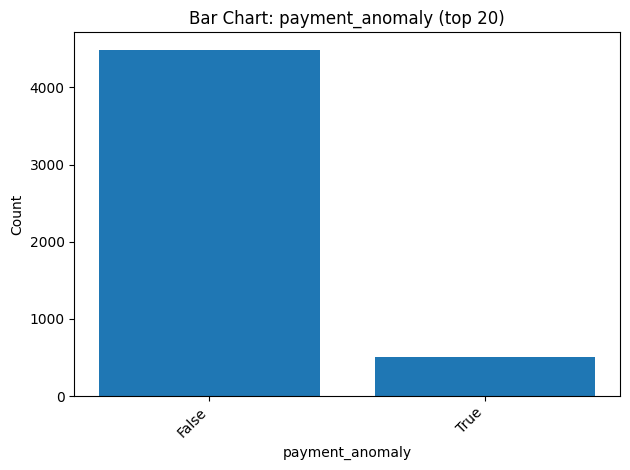

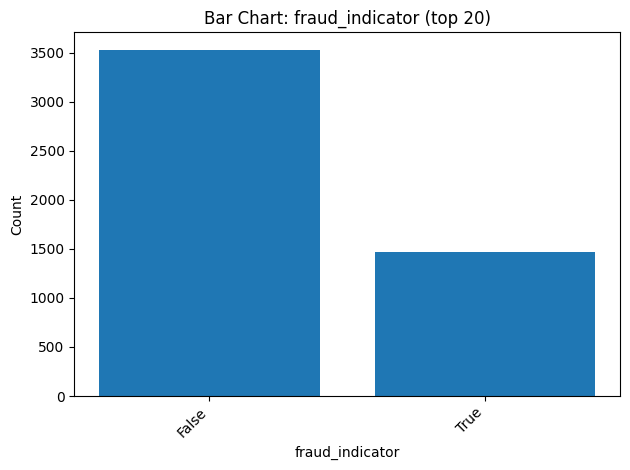

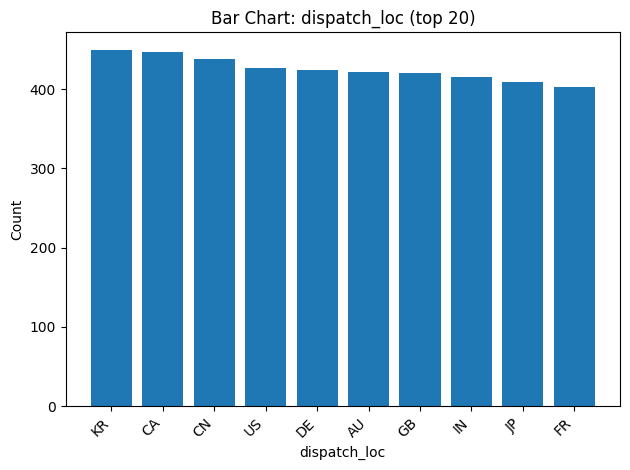

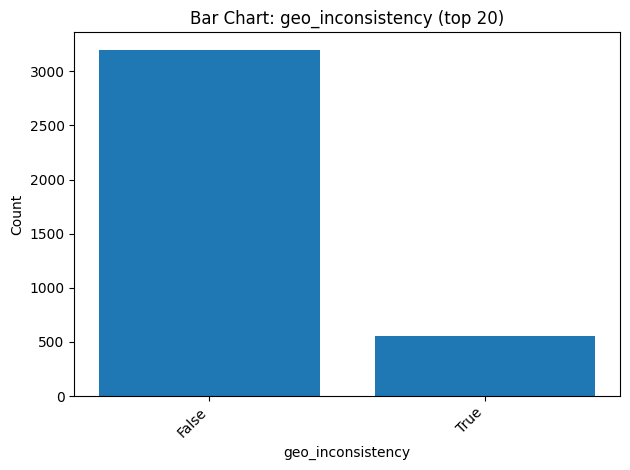

Saved distribution plots in: /content/eda_images


In [85]:
num_variances = df[num_cols_all].var(numeric_only=True).sort_values(ascending=False) if num_cols_all else pd.Series(dtype=float)
num_cols_plot = list(num_variances.head(12).index) if len(num_variances) > 0 else []

# - top 12 categorical by non-null count, with reasonable cardinality (<= 30)
cat_stats = []
for c in cat_cols_all:
    nn = int(df[c].notna().sum())
    nunq = int(df[c].nunique(dropna=True))
    if nunq <= 30:
        cat_stats.append((c, nn))
cat_cols_plot = [c for c, _ in sorted(cat_stats, key=lambda x: -x[1])[:12]]

# Numeric histograms
for col in num_cols_plot:
    ser = df[col].dropna()
    if ser.nunique() < 2:
        continue
    plt.figure()
    bins = min(40, max(10, int(np.sqrt(ser.nunique()))))
    plt.hist(ser, bins=bins)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(IMG_DIR / f"hist_{col}.png")
    plt.show()

# Categorical bar charts (top-k)
TOP_K = 20
for col in cat_cols_plot:
    vc = df[col].astype("category").value_counts().head(TOP_K)
    plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Bar Chart: {col} (top {TOP_K})")
    plt.xlabel(col); plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(IMG_DIR / f"bar_{col}.png")
    plt.show()

print(f"Saved distribution plots in: {IMG_DIR.resolve()}")

In [86]:
# Step 7 — Target variable Distribution

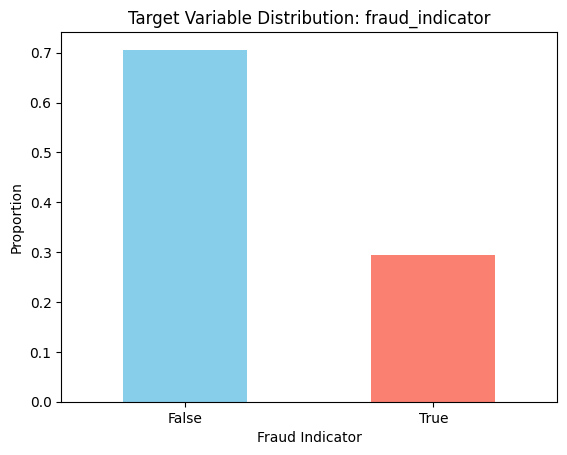

,proportion
fraud_indicator,
False,0.706
True,0.294


In [87]:
# Distribution of fraud_indicator
df['fraud_indicator'].value_counts(normalize=True).plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    rot=0
)
plt.title("Target Variable Distribution: fraud_indicator")
plt.xlabel("Fraud Indicator")
plt.ylabel("Proportion")
plt.show()

# Check class imbalance numerically
df['fraud_indicator'].value_counts(normalize=True)


In [89]:
# Step 8: Univariate Analysis (Features)

Numeric columns: ['cost_usd', 'vendor_score', 'feedback_count', 'image_qty', 'desc_chars', 'delivery_period', 'typo_count', 'site_age', 'payment_options', 'page_hits', 'sales_vol', 'saved_items', 'trust_seals', 'guarantee_term']
Categorical columns: Index(['item_ref', 'vendor_code', 'product_type', 'manufacturer',
       'post_timestamp', 'vendor_nation', 'dispatch_loc', 'geo_inconsistency'],
      dtype='object')
0       False
1        True
2        True
3       False
4       False
        ...  
4995    False
4996     True
4997    False
4998     True
4999    False
Name: fraud_indicator, Length: 5000, dtype: bool


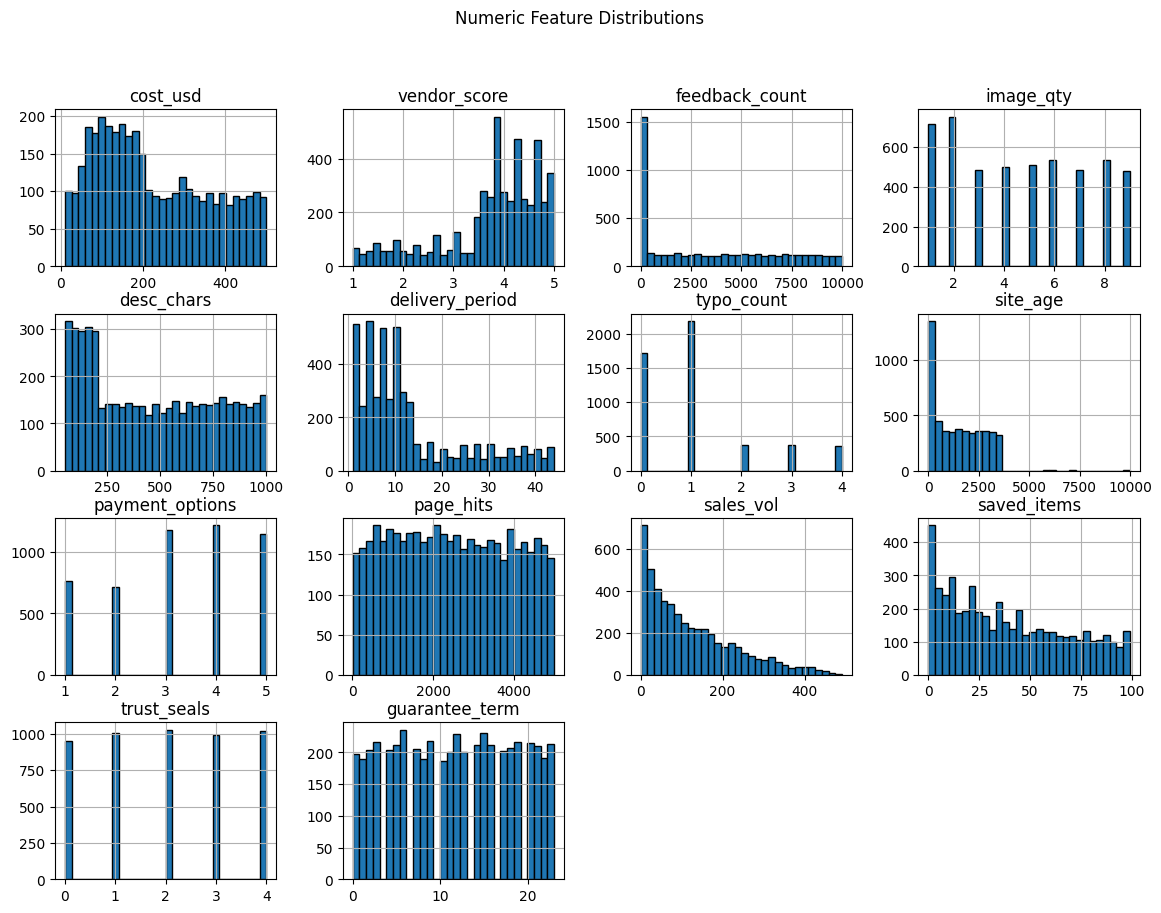

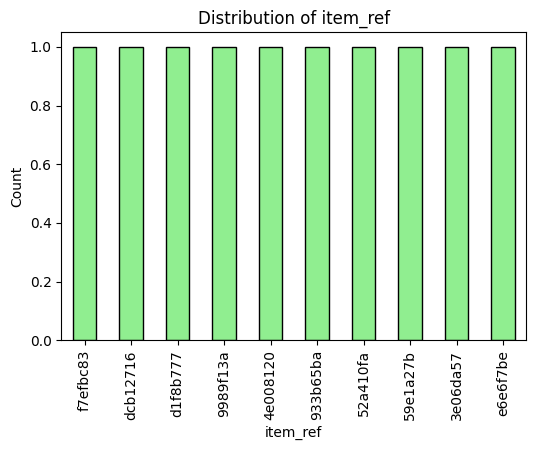

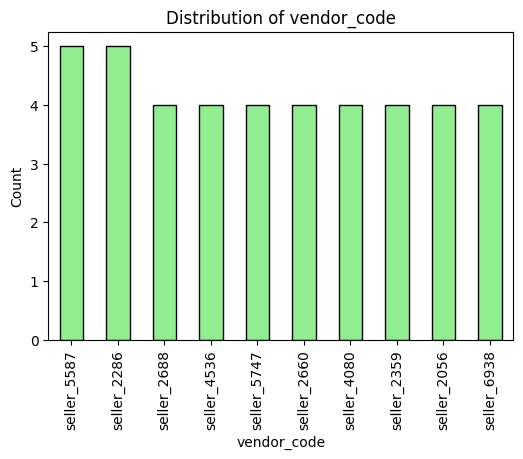

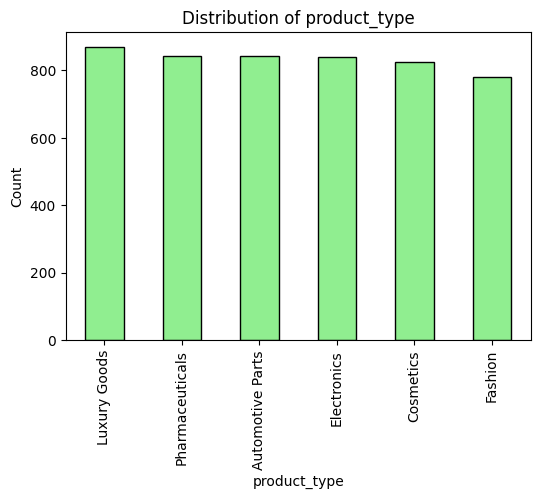

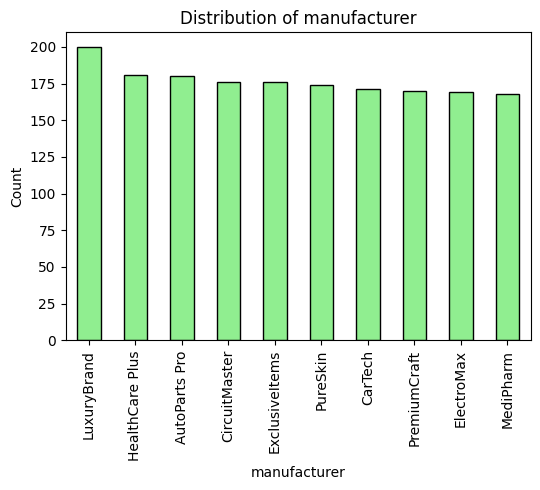

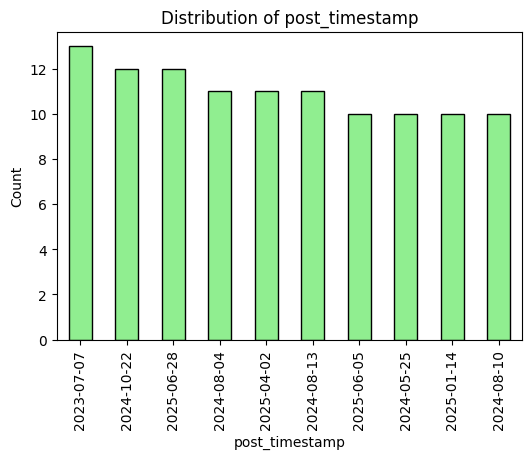

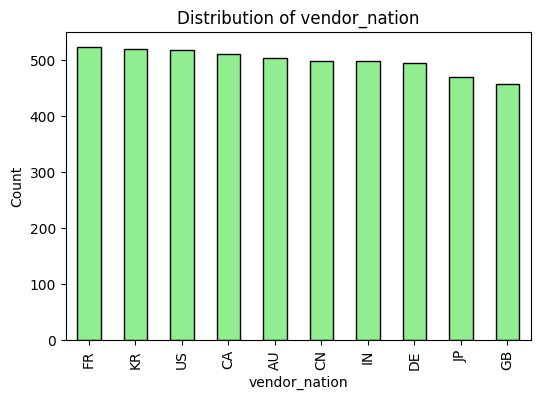

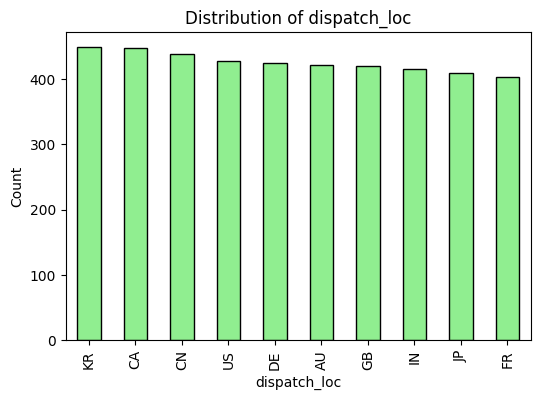

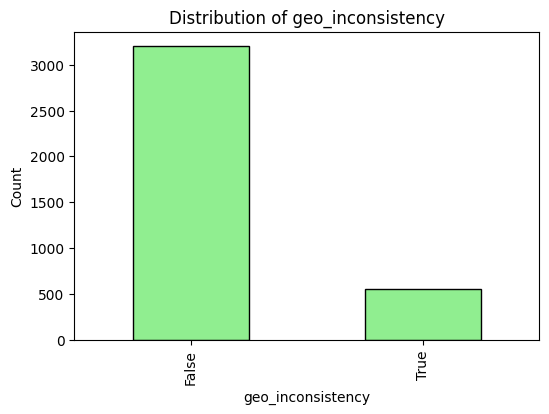

In [93]:
df['fraud_indicator'] = pd.to_numeric(df['fraud_indicator'], errors='coerce')
# ✅ Define numeric & categorical features
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                if col != 'fraud_indicator']
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print(df['fraud_indicator'])
# 8A: Histograms for numeric features
df[numeric_cols].hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Numeric Feature Distributions")
plt.show()

# 8B: Bar plots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    df[col].value_counts().head(10).plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.ylabel("Count")
    plt.show()

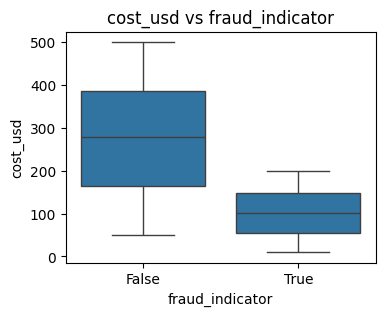

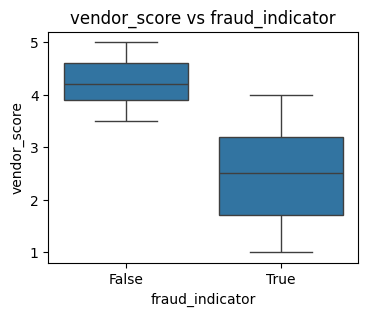

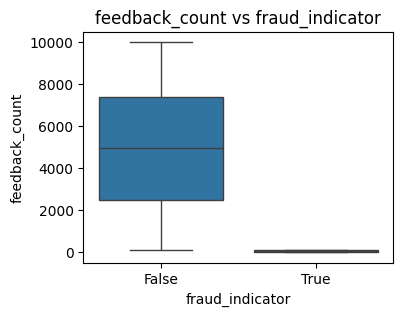

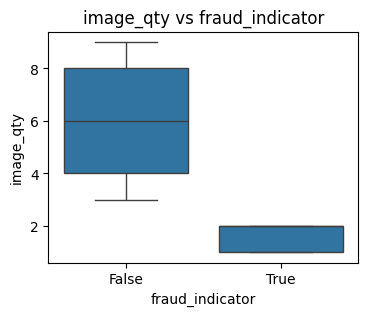

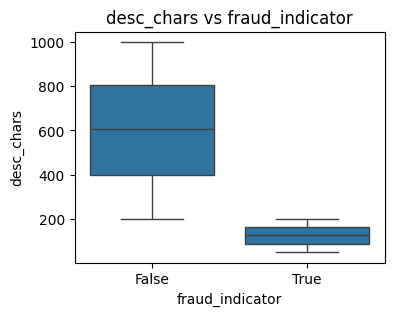

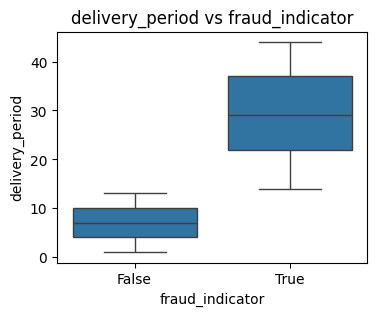

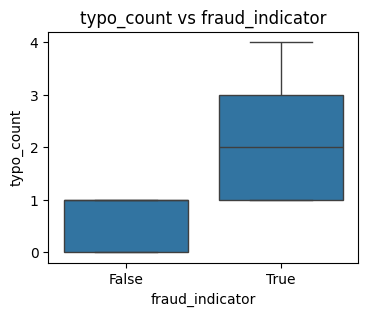

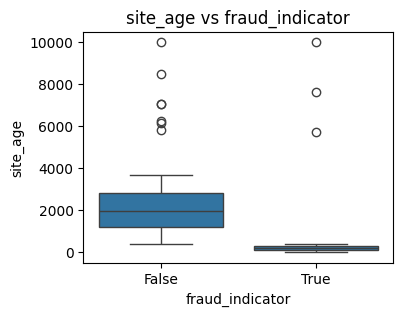

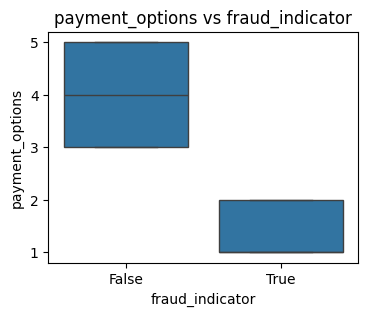

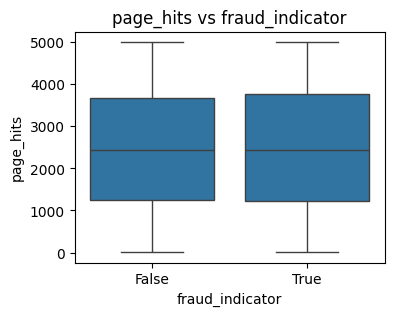

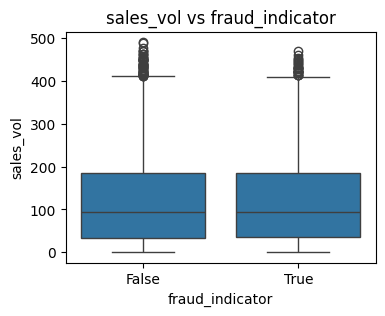

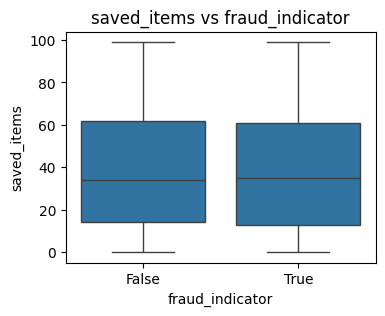

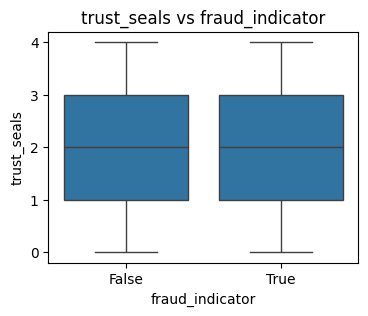

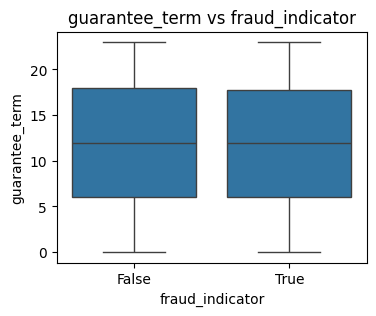

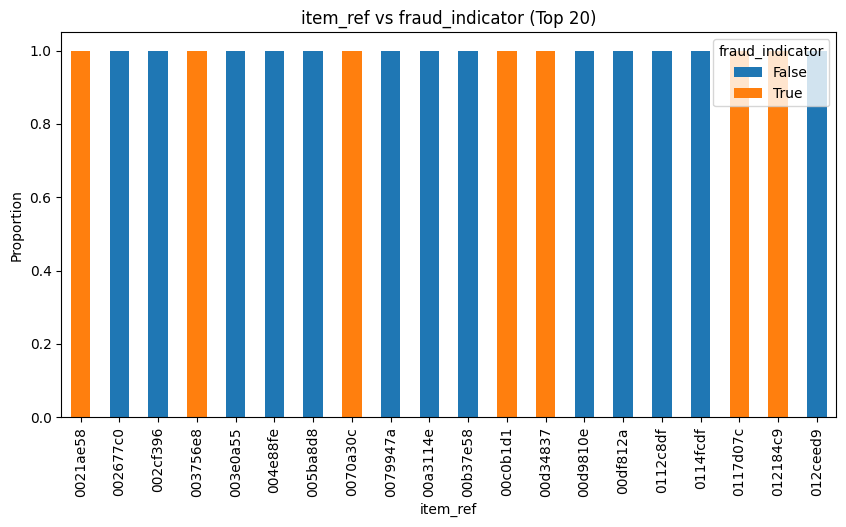

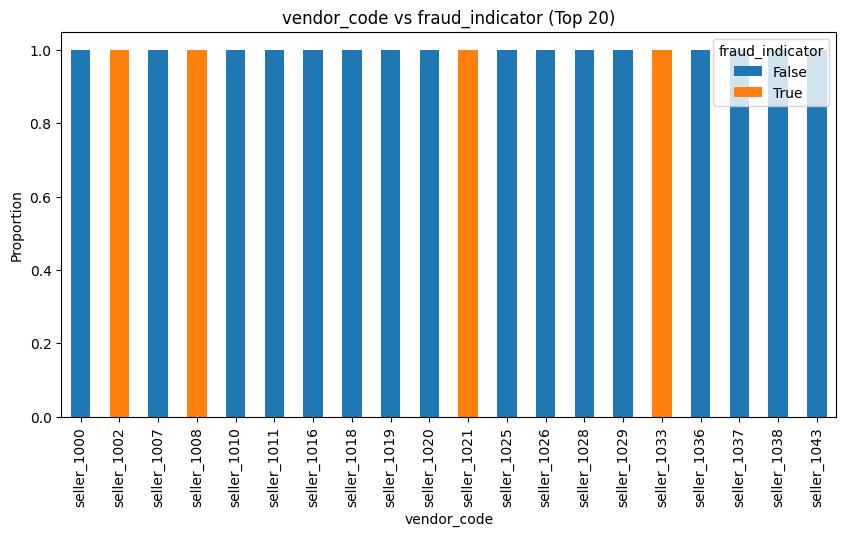

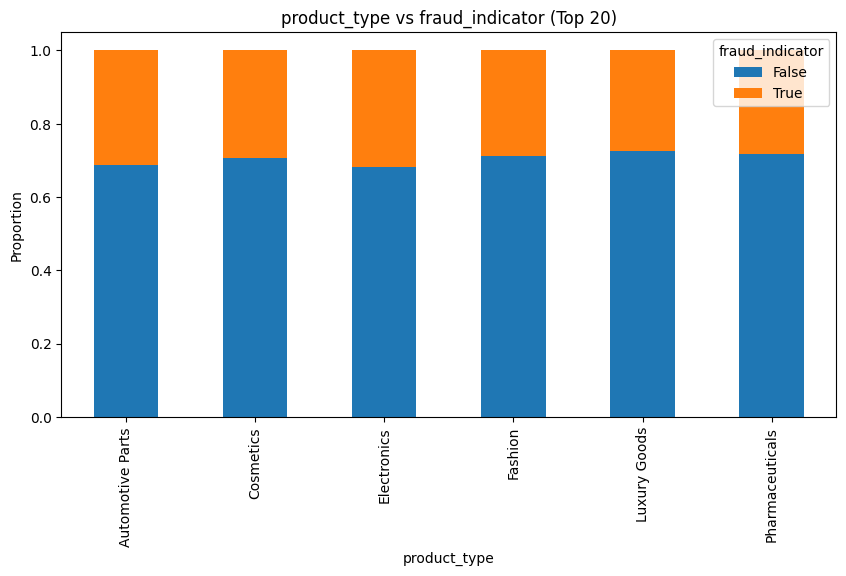

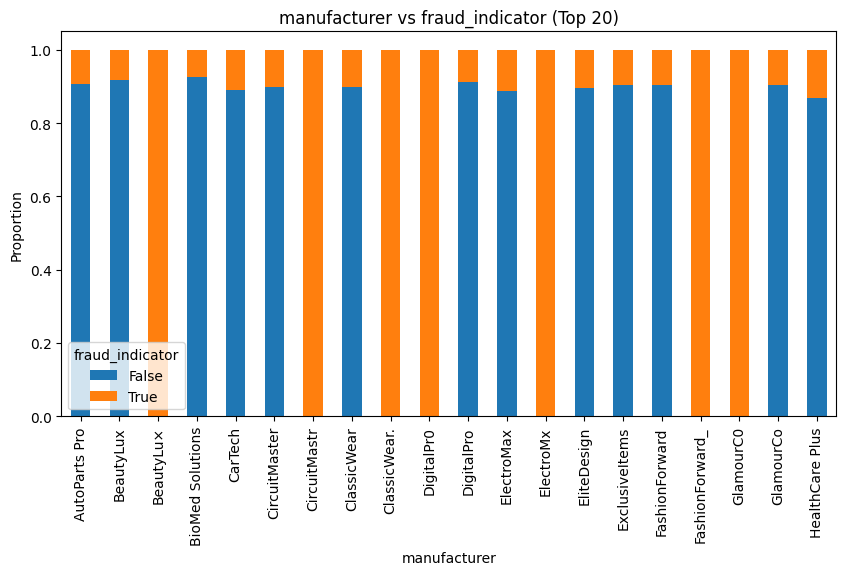

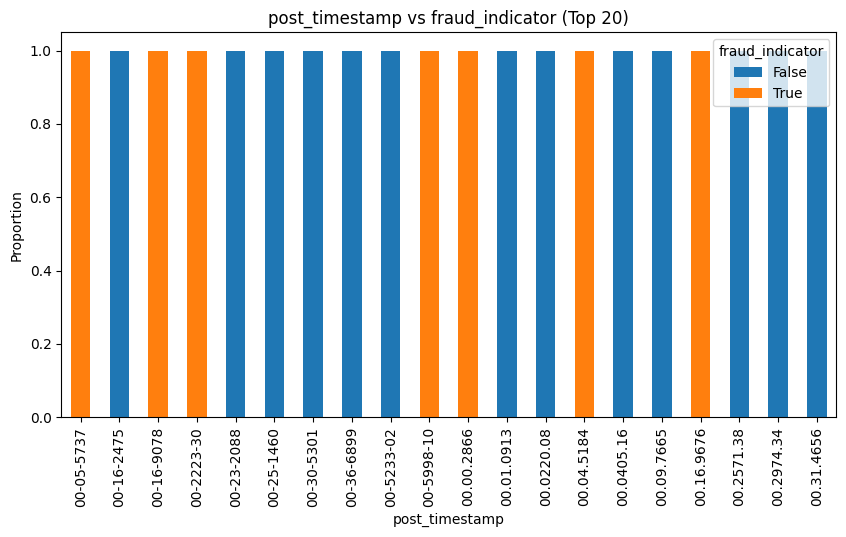

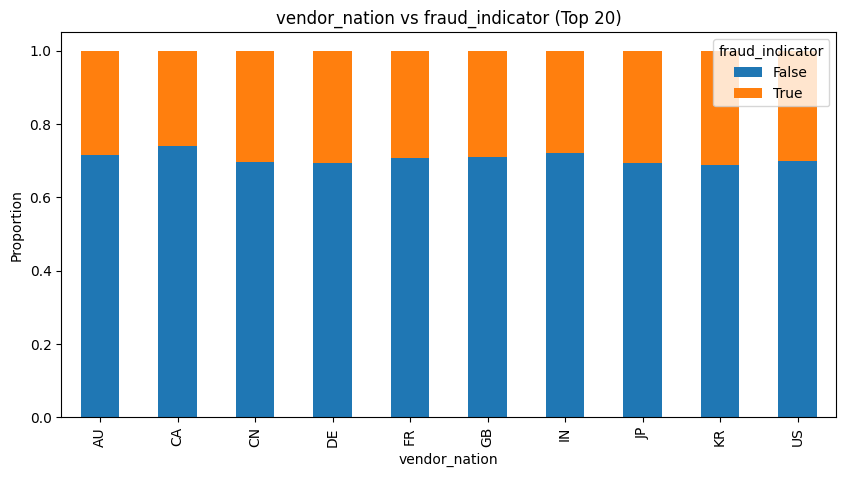

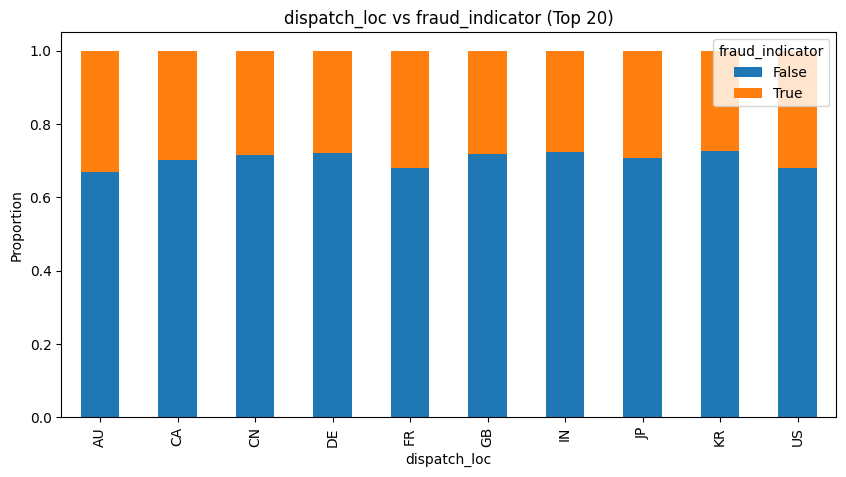

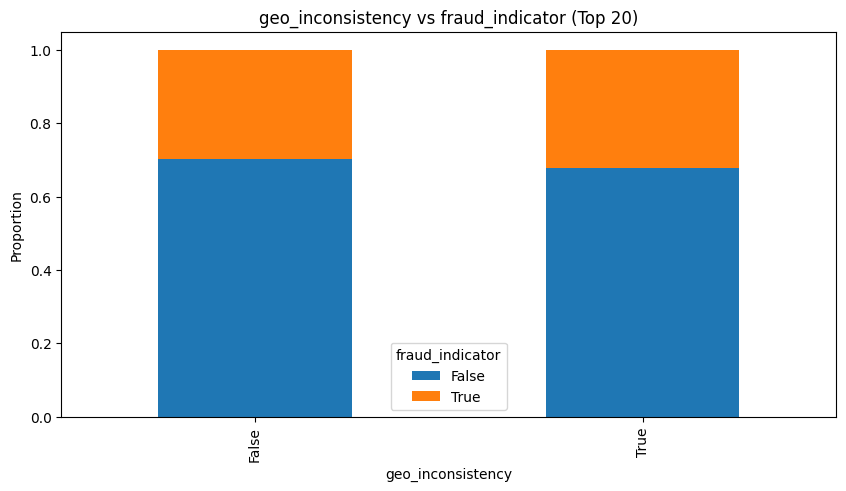

In [91]:
for col in numeric_cols:
    plt.figure(figsize=(4,3))
    sns.boxplot(x='fraud_indicator', y=col, data=df)
    plt.title(f"{col} vs fraud_indicator")
    plt.show()

# Categorical features vs fraud_indicator (cross-tab)
for col in categorical_cols:
    ct = pd.crosstab(df[col], df['fraud_indicator'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(8,4))
    plt.title(f"{col} vs fraud_indicator")
    plt.ylabel("Proportion")
    plt.show()

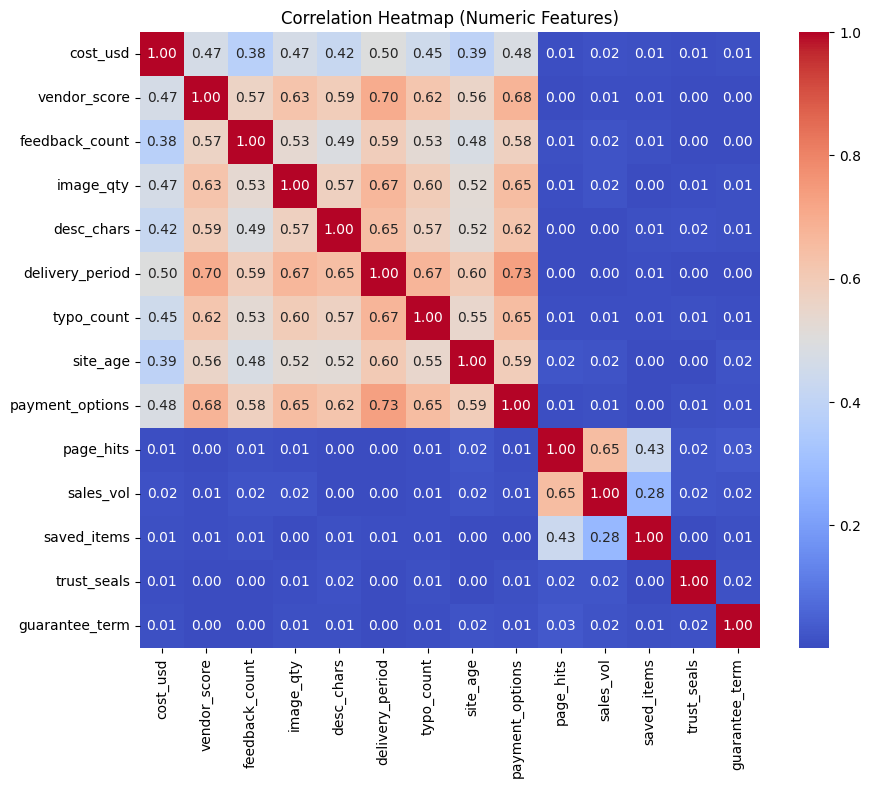

In [100]:
# Correlation matrix (numeric features only)
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr().abs(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

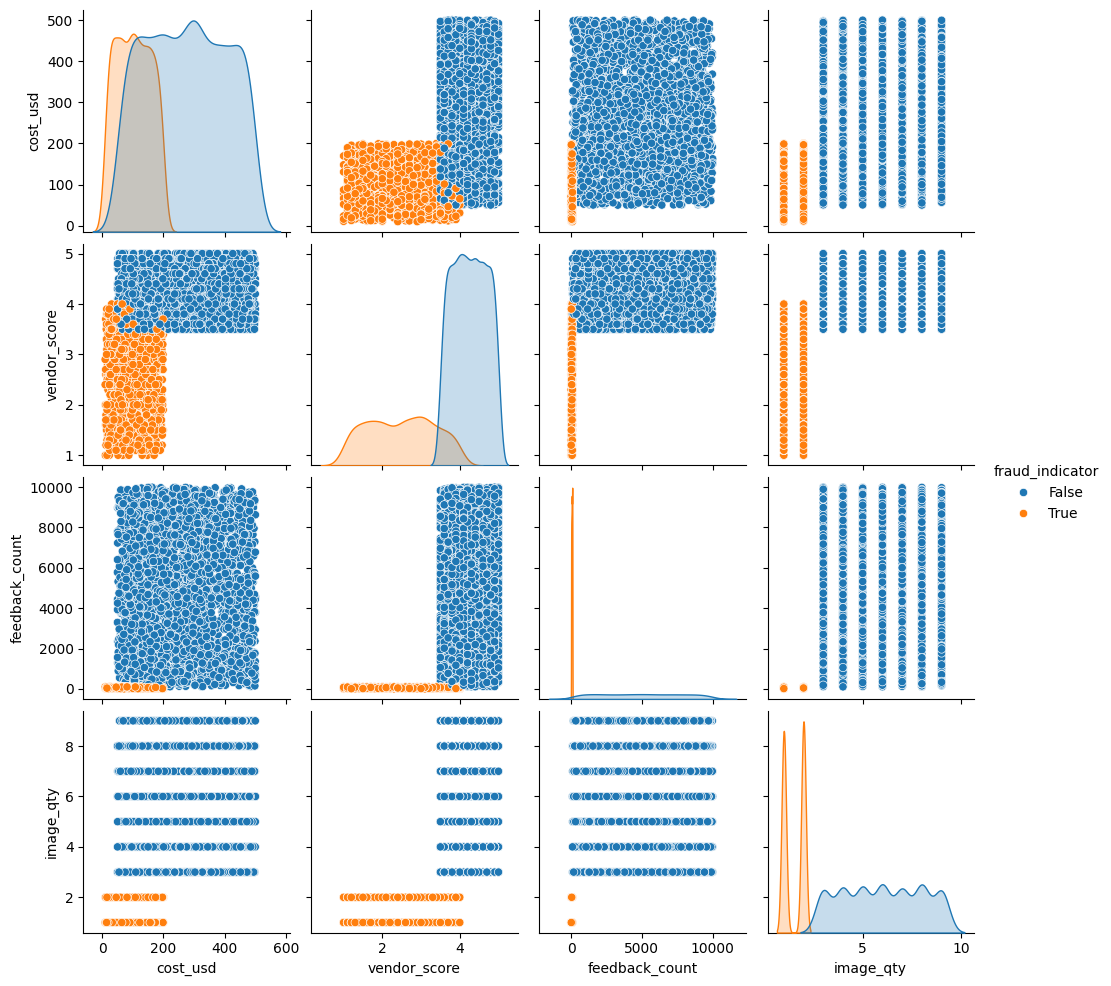

In [96]:
# Pairplot (only top correlated numeric features with fraud_indicator)
top_features = correlations.drop('fraud_indicator').abs().sort_values(ascending=False).head(4).index.tolist()
sns.pairplot(df[top_features + ['fraud_indicator']], hue='fraud_indicator')
plt.show()

In [101]:
### TASK2

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define features (X) and target (y)
X = df.drop("fraud_indicator", axis=1)
y = df["fraud_indicator"]

# Train/Validation/Test Split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=47, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4, stratify=y_temp)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

# Identify numeric & categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)])

Train: (3000, 26) Validation: (1000, 26) Test: (1000, 26)


In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression pipeline
logreg_clf = Pipeline(steps=[("preprocessor", preprocessor),
                             ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))])

# Random Forest pipeline
rf_clf = Pipeline(steps=[("preprocessor", preprocessor),
                         ("classifier", RandomForestClassifier(n_estimators=70, random_state=400, class_weight="balanced"))])

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred))
    print("Recall:", recall_score(y_val, y_pred))
    print("F1 Score:", f1_score(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_proba))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

# Train & evaluate Logistic Regression
print("🔹 Logistic Regression Results")
logreg_clf.fit(X_train, y_train)
evaluate_model(logreg_clf, X_val, y_val)

# Train & evaluate Random Forest
print("\n🔹 Random Forest Results")
rf_clf.fit(X_train, y_train)
evaluate_model(rf_clf, X_val, y_val)

🔹 Logistic Regression Results
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       706
        True       1.00      1.00      1.00       294

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


🔹 Random Forest Results
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       706
        True       1.00      1.00      1.00       294

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [119]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

logreg_scores = cross_val_score(logreg_clf, X, y, cv=cv, scoring="f1")
rf_scores = cross_val_score(rf_clf, X, y, cv=cv, scoring="f1")

print("Logistic Regression CV F1 Scores:", logreg_scores, "Mean:", logreg_scores.mean())
print("Random Forest CV F1 Scores:", rf_scores, "Mean:", rf_scores.mean())

Logistic Regression CV F1 Scores: [1.         1.         1.         0.99829642 1.        ] Mean: 0.9996592844974448
Random Forest CV F1 Scores: [1. 1. 1. 1. 1.] Mean: 1.0


In [120]:
best_model = logreg_clf  # (replace with logreg_clf if it performed better)

best_model.fit(X_train, y_train)
evaluate_model(best_model, X_test, y_test)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       706
        True       1.00      1.00      1.00       294

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [124]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = rf_clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[706   0]
 [  0 294]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       706
        True       1.00      1.00      1.00       294

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

